In [ ]:
import cv2
import numpy as np
import json
from collections import defaultdict

# ===================== Configuration =====================
panoptic_path = "xxx_panoptic_seg.png"
output_json_path = "output_stuff_coco.json"

# ===================== Read Image =====================
print("Reading panoptic image...")
pan = cv2.imread(panoptic_path, cv2.IMREAD_UNCHANGED)

if pan is None:
    raise FileNotFoundError("Could not read the panoptic image. Please check the path.")

# ===================== Decode Segment IDs =====================
# The panoptic image encodes segment IDs in its RGB channels.
R = pan[:, :, 2].astype(np.uint32)
G = pan[:, :, 1].astype(np.uint32)
B = pan[:, :, 0].astype(np.uint32)
segment_ids = (R << 16) | (G << 8) | B

unique_ids = np.unique(segment_ids)
# Ignore the background which is typically ID 0.
unique_ids = unique_ids[unique_ids != 0]
print(f"Total segments detected (including things and stuff): {len(unique_ids)}")

# ===================== Define Stuff Categories =====================
# For stuff, the category is determined by the R channel value,
# while G and B channels are 0.
stuff_r_to_name = {
    # 5: "tunnel",
    6: "equipments",
    7: "signs",
    8: "repaired_part"
}
stuff_names = list(stuff_r_to_name.values())
# Assign a unique COCO category ID to each stuff class.
category_id_map = {name: idx + 1 for idx, name in enumerate(stuff_names)}

# ===================== Initialization =====================
annotations = []
instance_id = 1
counts = defaultdict(int)
h, w = segment_ids.shape

# ===================== Process Each Segment =====================
for sid in unique_ids:
    # Decode the R, G, B values from the segment ID.
    r = (sid >> 16) & 255
    g = (sid >> 8) & 255
    b = sid & 255

    # --- Filter for Stuff Segments ---
    # According to the definition, stuff segments have G=0, B=0,
    # and a specific R value.
    if g == 0 and b == 0 and r in stuff_r_to_name:
        category_name = stuff_r_to_name[r]
        category_id = category_id_map[category_name]
        counts[category_name] += 1

        # Create a binary mask for the current segment.
        mask = (segment_ids == sid).astype(np.uint8)

        # Skip very small, likely noise-related segments.
        if cv2.countNonZero(mask) < 10:
            continue

        # --- Extract Contours for Segmentation ---
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        segmentations = []
        for c in contours:
            # A contour must have at least 3 points to form a polygon.
            if len(c) < 3:
                continue
            # Flatten the contour array and convert to a list of floats.
            segmentations.append(c.squeeze(1).astype(float).ravel().tolist())
        
        if not segmentations:
            continue

        # --- Calculate Bounding Box and Area ---
        x, y, w_box, h_box = cv2.boundingRect(mask)
        area = float(cv2.countNonZero(mask))

        # --- Append Annotation in COCO Format ---
        annotations.append({
            "id": instance_id,
            "image_id": 1,  # Assuming a single image
            "category_id": category_id,
            "bbox": [float(x), float(y), float(w_box), float(h_box)],
            "area": area,
            "segmentation": segmentations,
            "iscrowd": 0
        })
        instance_id += 1

# ===================== Print Statistics =====================
print(f"✅ Successfully generated COCO annotations for {len(annotations)} stuff instances.")
print("📊 Instance count per category:")
for name in stuff_names:
    print(f"  {name:<15}: {counts.get(name, 0)}")

# ===================== Generate COCO JSON Output =====================
coco_output = {
    "images": [{
        "file_name": panoptic_path,
        "height": h,
        "width": w,
        "id": 1
    }],
    "annotations": annotations,
    "categories": [{"id": cid, "name": name, "isthing": 0} for name, cid in category_id_map.items()]
}

with open(output_json_path, "w") as f:
    json.dump(coco_output, f, indent=4)

print(f"✅ COCO JSON for stuff categories has been saved to: {output_json_path}")

Reading panoptic image...
Total segments detected (including things and stuff): 147
✅ Successfully generated COCO annotations for 3 stuff instances.
📊 Instance count per category:
  equipments     : 1
  signs          : 1
  repaired_part  : 1
✅ COCO JSON for stuff categories has been saved to: output_stuff_coco.json


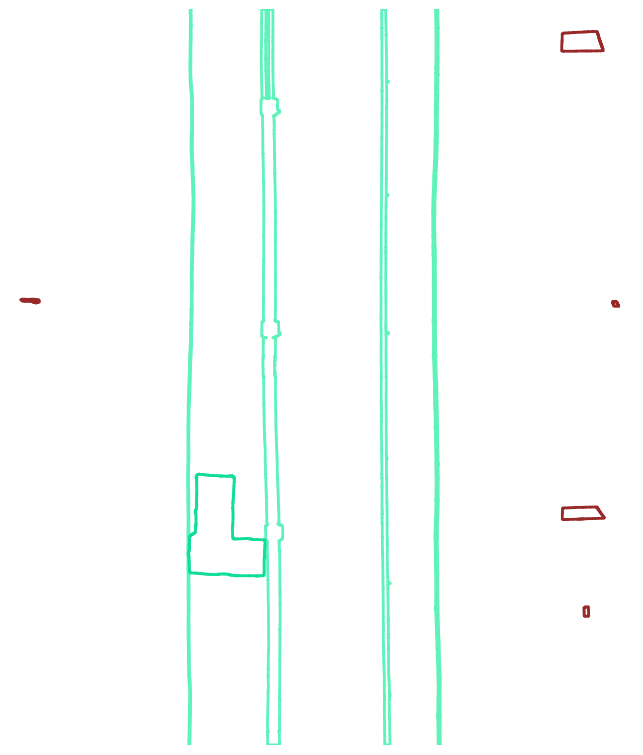

In [ ]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# ========== Configuration ==========
json_file = "output_stuff_coco.json"

# ========== read JSON ==========
with open(json_file) as f:
    coco = json.load(f)

# obtain size of image
image_info = coco["images"][0]
width, height = image_info["width"], image_info["height"]

# ========== canvas creation ==========
fig, ax = plt.subplots(figsize=(width/800, height/800))
ax.set_xlim(0, width)
ax.set_ylim(0, height)
ax.invert_yaxis()
ax.axis('off')

# ========== generate color for categories ==========
np.random.seed(42)
category_colors = {cat["id"]: np.random.rand(3,) for cat in coco["categories"]}

# ========== draw profile ==========
for ann in coco["annotations"]:
    color = category_colors[ann["category_id"]]
    for seg in ann["segmentation"]:
        pts = np.array(seg).reshape(-1, 2)
        polygon = patches.Polygon(pts, closed=True, fill=False, edgecolor=color, linewidth=2)
        ax.add_patch(polygon)

plt.show()


In [15]:
import json
import numpy as np
from shapely.geometry import Polygon
from shapely.ops import unary_union
from tqdm import tqdm

# ===================== Configuration =====================
input_json = "output_stuff_coco.json"
output_json = "output_stuff_simplified_coco.json"

# The tolerance for simplification in pixels. A higher value results in
# simpler polygons with fewer points. Adjust based on your needs.
simplify_tolerance = 5

# ===================== Read COCO JSON =====================
print(f"Reading COCO data from: {input_json}")
try:
    with open(input_json) as f:
        coco_data = json.load(f)
except FileNotFoundError:
    print(f"Error: Input file not found at '{input_json}'. Please check the path.")
    exit()

annotations = coco_data.get("annotations", [])
simplified_annotations = []
new_instance_id = 1

print(f"Found {len(annotations)} instances to process.")

# ===================== Simplify Contours =====================
# Use tqdm for a progress bar as this can be time-consuming for many complex objects.
for ann in tqdm(annotations, desc="Simplifying instances"):
    segmentations = ann.get("segmentation", [])
    shapely_polygons = []

    # --- Step 1: Convert COCO segmentations to Shapely Polygon objects ---
    for seg in segmentations:
        points = np.array(seg).reshape(-1, 2)
        # A valid polygon requires at least 3 points.
        if points.shape[0] >= 3:
            poly = Polygon(points)
            # Fix invalid polygons (e.g., self-intersecting) using a zero-buffer trick.
            if not poly.is_valid:
                poly = poly.buffer(0)
            # Only add valid polygons with a positive area.
            if poly.is_valid and poly.area > 0:
                shapely_polygons.append(poly)

    if not shapely_polygons:
        continue

    # --- Step 2: Merge all polygons for the instance into a single geometry ---
    # This handles cases where one instance consists of multiple disjointed parts.
    merged_geometry = unary_union(shapely_polygons)

    # --- Step 3: Apply the simplification algorithm ---
    simplified_geometry = merged_geometry.simplify(simplify_tolerance, preserve_topology=True)

    # --- Step 4: Convert the simplified geometry back to COCO format ---
    output_segmentations = []
    if simplified_geometry.geom_type == 'Polygon':
        # Handle single polygons
        if not simplified_geometry.exterior.is_empty:
             output_segmentations.append(np.array(simplified_geometry.exterior.coords).ravel().tolist())
    elif simplified_geometry.geom_type == 'MultiPolygon':
        # Handle multiple disjoint polygons
        for p in simplified_geometry.geoms:
             if not p.exterior.is_empty:
                output_segmentations.append(np.array(p.exterior.coords).ravel().tolist())
    
    if not output_segmentations:
        continue

    # --- Step 5: Recalculate bounding box and area from the simplified shape ---
    x_min, y_min, x_max, y_max = simplified_geometry.bounds
    bbox = [float(x_min), float(y_min), float(x_max - x_min), float(y_max - y_min)]
    area = float(simplified_geometry.area)

    simplified_annotations.append({
        "id": new_instance_id,
        "image_id": ann["image_id"],
        "category_id": ann["category_id"],
        "bbox": bbox,
        "area": area,
        "segmentation": output_segmentations,
        "iscrowd": ann.get("iscrowd", 0)
    })
    new_instance_id += 1

# ===================== Output Simplified JSON =====================
coco_output = {
    "images": coco_data.get("images", []),
    "annotations": simplified_annotations,
    "categories": coco_data.get("categories", [])
}

print("\nWriting simplified data to new JSON file...")
with open(output_json, "w") as f:
    json.dump(coco_output, f, indent=2)

print(f"✅ Simplified COCO JSON has been saved to: {output_json}")
print(f"Original instance count: {len(annotations)}")
print(f"Simplified instance count: {len(simplified_annotations)}")

Reading COCO data from: output_stuff_coco.json
Found 3 instances to process.


Simplifying instances: 100%|██████████| 3/3 [00:00<00:00, 179.34it/s]


Writing simplified data to new JSON file...
✅ Simplified COCO JSON has been saved to: output_stuff_simplified_coco.json
Original instance count: 3
Simplified instance count: 3


In [16]:
import json
import csv
import numpy as np

# ===================== Configuration =====================
input_json_path = "output_stuff_simplified_coco.json"
output_csv_path = "stuff_2d_points.csv"
# =========================================================

# ===================== 1. Load COCO JSON Data =====================
print(f"Loading data from: {input_json_path}")
try:
    with open(input_json_path, 'r') as f:
        coco_data = json.load(f)
except FileNotFoundError:
    print(f"Error: The file '{input_json_path}' was not found. Please check the path.")
    exit()

# Build a mapping from category_id to category_name for easy lookup
cat_id_to_name = {cat["id"]: cat["name"] for cat in coco_data.get("categories", [])}
if not cat_id_to_name:
    print("Warning: No categories found in the JSON file.")

# ===================== 2. Split Multi-Polygon Instances =====================
print("Processing and splitting multi-part instances...")
processed_annotations = []
# Find the highest existing ID to start new IDs from there
max_id = 0
if coco_data.get('annotations'):
    max_id = max(ann.get('id', 0) for ann in coco_data['annotations'])
new_instance_id_counter = max_id + 1

original_ann_count = len(coco_data.get('annotations', []))

for ann in coco_data.get('annotations', []):
    segmentations = ann.get('segmentation', [])
    
    # Case 1: The instance has only one polygon segment. Keep it as is.
    if len(segmentations) == 1:
        processed_annotations.append(ann)
        
    # Case 2: The instance has multiple polygon segments. Split them into new annotations.
    elif len(segmentations) > 1:
        for seg in segmentations:
            # Create a new annotation for each individual polygon
            new_ann = {
                "id": new_instance_id_counter,
                "image_id": ann.get("image_id"),
                "category_id": ann.get("category_id"),
                "segmentation": [seg]  # Each new annotation has only one segment
            }
            processed_annotations.append(new_ann)
            new_instance_id_counter += 1

print(f"Processing complete! Original {original_ann_count} instances resulted in {len(processed_annotations)} single-polygon instances.")

# ===================== 3. Generate CSV from Processed Annotations =====================
print(f"Generating CSV file: {output_csv_path}")
try:
    with open(output_csv_path, "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        
        # Write the header row
        writer.writerow(["instance_id", "category_name", "x", "y"])
        
        # Write the data rows
        for ann in processed_annotations:
            instance_id = ann["id"]
            category_name = cat_id_to_name.get(ann["category_id"], "unknown")
            
            # Each annotation now has exactly one polygon in its 'segmentation' list
            segment = ann["segmentation"][0]
            
            # Reshape the flat list of coordinates into (x, y) pairs
            points = np.array(segment).reshape(-1, 2).astype(int)
            
            # Write each point to a new row in the CSV
            for x, y in points:
                writer.writerow([instance_id, category_name, x, y])

    print(f"✅ CSV file has been successfully generated: {output_csv_path}")

except Exception as e:
    print(f"An error occurred while writing the CSV file: {e}")

Loading data from: output_stuff_simplified_coco.json
Processing and splitting multi-part instances...
Processing complete! Original 3 instances resulted in 10 single-polygon instances.
Generating CSV file: stuff_2d_points.csv
✅ CSV file has been successfully generated: stuff_2d_points.csv


In [38]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

# ===================== Configuration =====================
input_csv = "stuff_2d_points.csv"
output_csv = "stuff_2d_points_simplified.csv" # Changed output name

# ⚙️ New Parameter: Simplification Tolerance (epsilon)
# This is the maximum distance between the original curve and its approximation.
# - Smaller epsilon (e.g., 0.5, 1.0) = MORE detail, more points.
# - Larger epsilon (e.g., 5.0, 10.0) = LESS detail, fewer points.
epsilon = 30
# =========================================================

# ===================== Load Data =====================
print(f"Loading data from {input_csv}...")
try:
    df = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: Input file not found at '{input_csv}'. Please check the path.")
    exit()

groups = df.groupby('instance_id')
print(f"Data loaded. Found {len(groups)} unique instances to process.")

all_new_rows = []

# ===================== Core Processing Loop =====================
print(f"Simplifying each instance with epsilon = {epsilon}...")
for instance_id, group in tqdm(groups, desc="Processing Instances"):
    
    # --- 1. Inherit Metadata ---
    first_row = group.iloc[0]
    category_name = first_row['category_name']
    
    # --- 2. Extract Points and Simplify the Polygon ---
    points = group[['x', 'y']].values.astype(np.int32)
    
    if len(points) < 3:
        continue

    try:
        # === CORE CHANGE: Replace convexHull with approxPolyDP ===
        # Use the Douglas-Peucker algorithm to simplify the polygon
        # while preserving its shape and concavities.
        simplified_points = cv2.approxPolyDP(points, epsilon, closed=True)

        # --- 3. Generate New Rows for Output ---
        if simplified_points is not None and len(simplified_points) >= 3:
            # The output shape is (N, 1, 2), reshape it to (N, 2).
            optimized_points = simplified_points.reshape(-1, 2)
            
            for x, y in optimized_points:
                all_new_rows.append([instance_id, category_name, x, y])

    except Exception as e:
        print(f"\nWarning: Skipped instance ID {instance_id} due to an error: {e}")
        continue

# ===================== Save Results =====================
print("\nProcessing complete. Saving results to new CSV file...")
if all_new_rows:
    output_df = pd.DataFrame(all_new_rows, columns=df.columns)
    output_df.to_csv(output_csv, index=False)
    print(f"✅ Simplified data has been saved to: {output_csv}")
else:
    print("Warning: No valid simplified points were generated. The output file was not created.")

Loading data from stuff_2d_points.csv...
Data loaded. Found 10 unique instances to process.
Simplifying each instance with epsilon = 30...


Processing Instances: 100%|██████████| 10/10 [00:00<00:00, 1651.24it/s]


Processing complete. Saving results to new CSV file...
✅ Simplified data has been saved to: stuff_2d_points_simplified.csv


Loaded 50 points from stuff_2d_points_simplified.csv.
Data contains 8 unique instances.

Starting to plot outlines. Instances with fewer than 2 points will be ignored...
Plotting complete! Displaying outlines for 8 / 8 instances.


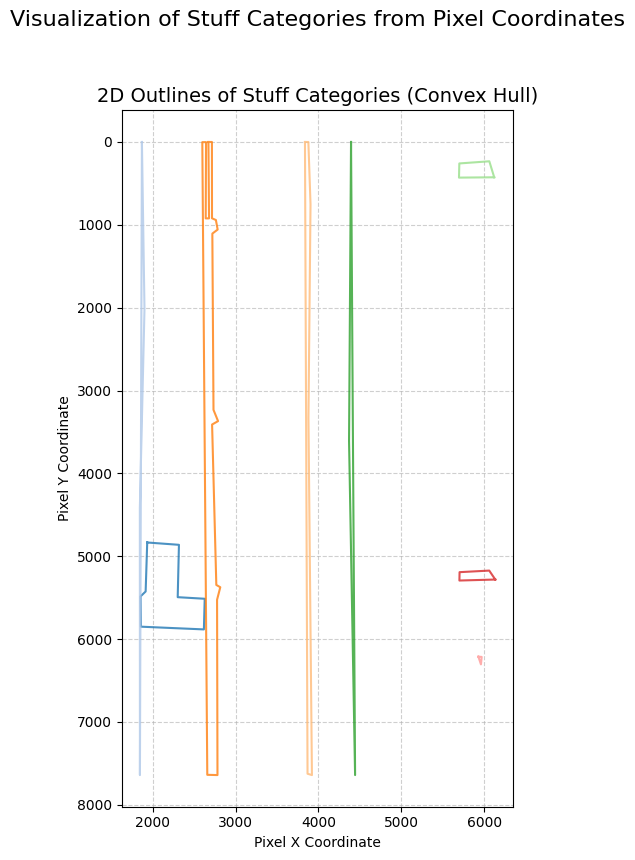

In [39]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ====================================================
# Configuration
csv_path = "stuff_2d_points_simplified.csv"

# For drawing lines, we need at least 2 points.
MIN_POINTS_THRESHOLD = 2

# ====================================================
# 1. Load Data
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{csv_path}'. Please ensure the path is correct.")
    exit()

# Ensure correct data types
df = df.dropna(subset=["x", "y"])
df[["x", "y"]] = df[["x", "y"]].astype(float)
df["instance_id"] = df["instance_id"].astype(int)
print(f"Loaded {len(df)} points from {csv_path}.")

# ====================================================
# 2. Group by Instance ID
groups = df.groupby("instance_id")
print(f"Data contains {len(groups)} unique instances.")

# ====================================================
# 3. Prepare for Plotting
fig, ax = plt.subplots(figsize=(12, 9)) # Simplified to a single plot

# Color map for distinguishing different instances
cmap = plt.colormaps.get_cmap("tab20")

# ====================================================
# 4. Iterate Through Each Group and Plot the Outline
drawn_count = 0
print(f"\nStarting to plot outlines. Instances with fewer than {MIN_POINTS_THRESHOLD} points will be ignored...")

for i, (name, group) in enumerate(groups):
    if len(group) < MIN_POINTS_THRESHOLD:
        continue
        
    points = group[["x", "y"]].values
    
    # To close the polygon shape, we need to add the first point to the end of the array
    closed_points = np.vstack([points, points[0]])
    
    # Separate the X and Y coordinates for plotting
    x_coords = closed_points[:, 0]
    y_coords = closed_points[:, 1]
    
    # Plot instance outline, colored by its ID
    instance_color = cmap(i % cmap.N)
    ax.plot(x_coords, y_coords, color=instance_color, linewidth=1.5, alpha=0.8, label=f'Instance {name}' if i < 15 else "") # Label first few for legend
    
    drawn_count += 1

print(f"Plotting complete! Displaying outlines for {drawn_count} / {len(groups)} instances.")

# ====================================================
# 5. Set Graph Properties
ax.set_aspect('equal')
ax.autoscale_view()
ax.invert_yaxis() # Often needed for image coordinates where (0,0) is top-left
ax.set_xlabel("Pixel X Coordinate")
ax.set_ylabel("Pixel Y Coordinate")
ax.grid(True, linestyle='--', alpha=0.6)

ax.set_title("2D Outlines of Stuff Categories (Convex Hull)", fontsize=14)
plt.suptitle("Visualization of Stuff Categories from Pixel Coordinates", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [40]:
import pandas as pd
import numpy as np
from PIL import Image

# ===================== Configuration =====================
input_csv = "stuff_2d_points_simplified.csv"
output_csv = "stuff_3d_points.csv" # Renamed for clarity
panoptic_img_path = "Galleria SESTRI DX A10_s07_panoptic_seg.png"

# Tunnel parameters
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
L = 20.0        # Tunnel length (m)
# =========================================================

# --- 1. Get Image Dimensions and Calculate Constants ---
try:
    with Image.open(panoptic_img_path) as img:
        img_width, img_height = img.size
except FileNotFoundError:
    print(f"Error: Panoptic image not found at '{panoptic_img_path}'. Cannot determine image dimensions.")
    exit()

# Total angle of the arc in radians
theta_max = s / r

# Calculate the Z-offset to set the bottom of the tunnel arc to Z=0
Z_offset = r * np.cos(theta_max / 2)

print(f"Image Dimensions: {img_width}px width, {img_height}px height")
print(f"Calculated Arc Angle (theta_max): {np.degrees(theta_max):.2f}°")
print(f"Calculated Z-Offset: {Z_offset:.3f} m")

# --- 2. Load Data and Perform 3D Projection ---
print(f"\nReading data from '{input_csv}'...")
try:
    df = pd.read_csv(input_csv)
except FileNotFoundError:
    print(f"Error: Input CSV not found at '{input_csv}'.")
    exit()

# Convert pixel coordinates to float type for calculations
df['x_img'] = df['x'].astype(float)
df['y_img'] = df['y'].astype(float)

# --- Vectorized Calculations (applied to all rows at once) ---

# Map the image's x-coordinate to the tunnel's arc length
s_i = (df['x_img'] / img_width) * s

# Calculate the angle for each point along the arc
# The angle is centered, from -theta_max/2 to +theta_max/2
theta = (s_i / r) - (theta_max / 2)

# Project the arc onto the X-Z plane and shift to start at X=0
X_3d = r * np.sin(theta) + r * np.sin(theta_max / 2)
Z_3d = r * np.cos(theta) - Z_offset

# Map the image's y-coordinate to the tunnel's length (Y-axis)
Y_3d = (df['y_img'] / img_height) * L

# --- 3. Create and Save the Output CSV ---

# Create a new DataFrame with the 3D coordinates
output_df = pd.DataFrame({
    'instance_id': df['instance_id'],
    'category_name': df['category_name'],
    'x': np.round(X_3d, 3), # Using 3 decimal places for better precision
    'y': np.round(Y_3d, 3),
    'z': np.round(Z_3d, 3)
})

# Save the new DataFrame to a CSV file
output_df.to_csv(output_csv, index=False)

print(f"✅ 3D projection complete. Data saved to: '{output_csv}'")

Image Dimensions: 6432px width, 7642px height
Calculated Arc Angle (theta_max): 211.71°
Calculated Z-Offset: -1.380 m

Reading data from 'stuff_2d_points_simplified.csv'...
✅ 3D projection complete. Data saved to: 'stuff_3d_points.csv'


Image width from source: 6432px
Filtering data to X-range (m): 0.518 to 9.198
Points remaining after filtering: 39


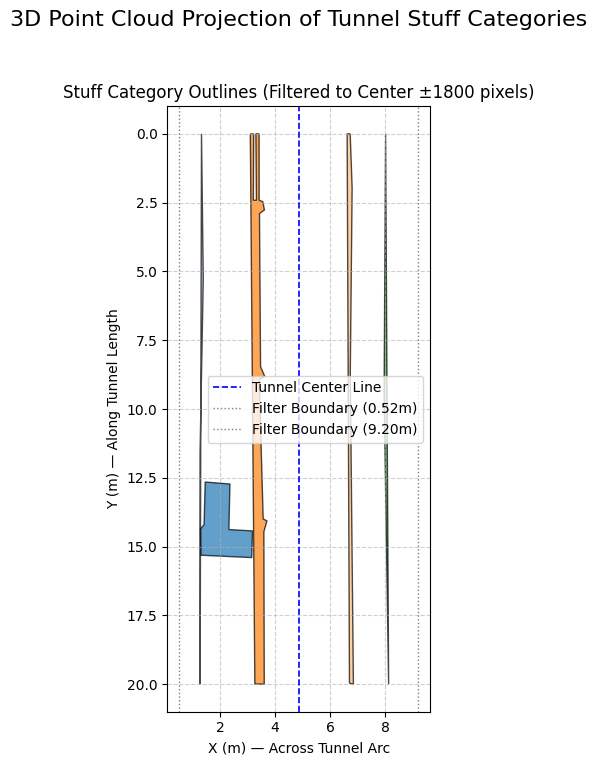

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np
import cv2

# ====================================================
# Configuration
csv_path = "stuff_3d_points.csv"
panoptic_img_path = "Galleria SESTRI DX A10_s07_panoptic_seg.png"

# Tunnel geometry parameters (must match the 3D projection script)
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
L = 20.0        # Tunnel length (m)
pix_range = 1800  # Filter: pixel range from the center line

# ====================================================
# Load Data
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{csv_path}'. Please ensure the path is correct.")
    exit()

# Ensure correct data types
df = df.dropna(subset=["x", "y"])
df[["x", "y"]] = df[["x", "y"]].astype(float)
df["instance_id"] = df["instance_id"].astype(str)

# ====================================================
# Get original image dimensions for calculations
try:
    img = cv2.imread(panoptic_img_path)
    height_img, width_img = img.shape[:2]
    print(f"Image width from source: {width_img}px")
except (AttributeError, TypeError):
    print(f"Error: Could not read image file '{panoptic_img_path}'. Please check the path.")
    exit()

# ====================================================
# Calculate the 3D coordinate range corresponding to the pixel filter
theta_max = s / r
half_span = r * np.sin(theta_max / 2) # This is the shift from a raw coordinate system to the one starting at X=0

# 1. Calculate the angle from the center to the pixel range boundary
theta_at_range = (pix_range / width_img) * theta_max

# 2. Project this angle onto the horizontal X-axis to find the raw coordinate
X_boundary_raw = r * np.sin(theta_at_range)

# 3. Convert the raw coordinate range [-X, +X] to the shifted coordinate system [0, 2*half_span]
X_filter_min = -X_boundary_raw + half_span
X_filter_max = X_boundary_raw + half_span

print(f"Filtering data to X-range (m): {X_filter_min:.3f} to {X_filter_max:.3f}")

# ====================================================
# Apply the filter and group the data
df_filtered = df[(df["x"] >= X_filter_min) & (df["x"] <= X_filter_max)]
print(f"Points remaining after filtering: {len(df_filtered)}")

groups = df_filtered.groupby("instance_id")

# Color mapping for instances
cmap = plt.colormaps.get("tab20")
num_groups = len(groups)

# ====================================================
# Create the Plot
fig, ax = plt.subplots(figsize=(10, 8)) # Simplified to a single subplot

for i, (name, group) in enumerate(groups):
    points = group[["x", "y"]].values
    
    # Ensure the polygon is closed for correct filling
    if len(points) >= 3:
        if not np.array_equal(points[0], points[-1]):
            points = np.vstack([points, points[0]])

        color = cmap(i % cmap.N)
        polygon = MplPolygon(points, closed=True, facecolor=color, edgecolor='black', alpha=0.7)
        ax.add_patch(polygon)

# ====================================================
# Set Plot Properties and Add Helper Lines
ax.axvline(x=half_span, color='blue', linestyle='--', lw=1.2, label="Tunnel Center Line")
ax.axvline(x=X_filter_min, color='gray', linestyle=':', lw=1, label=f'Filter Boundary ({X_filter_min:.2f}m)')
ax.axvline(x=X_filter_max, color='gray', linestyle=':', lw=1, label=f'Filter Boundary ({X_filter_max:.2f}m)')

ax.set_aspect('equal')
ax.autoscale()
ax.set_xlabel("X (m) — Across Tunnel Arc")
ax.set_ylabel("Y (m) — Along Tunnel Length")
ax.invert_yaxis()
ax.legend()
ax.grid(True, linestyle='--', alpha=0.6)

ax.set_title(f"Stuff Category Outlines (Filtered to Center ±{pix_range} pixels)")
plt.suptitle("3D Point Cloud Projection of Tunnel Stuff Categories", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Defining left/right zones using X-boundary: < 0.518 m and > 9.198 m

Found 0 unique instances in the Left Zone.
Found 3 unique instances in the Right Zone.

No instances found in the Left Zone. Skipping plot.

Generating visualization for Right Zone...


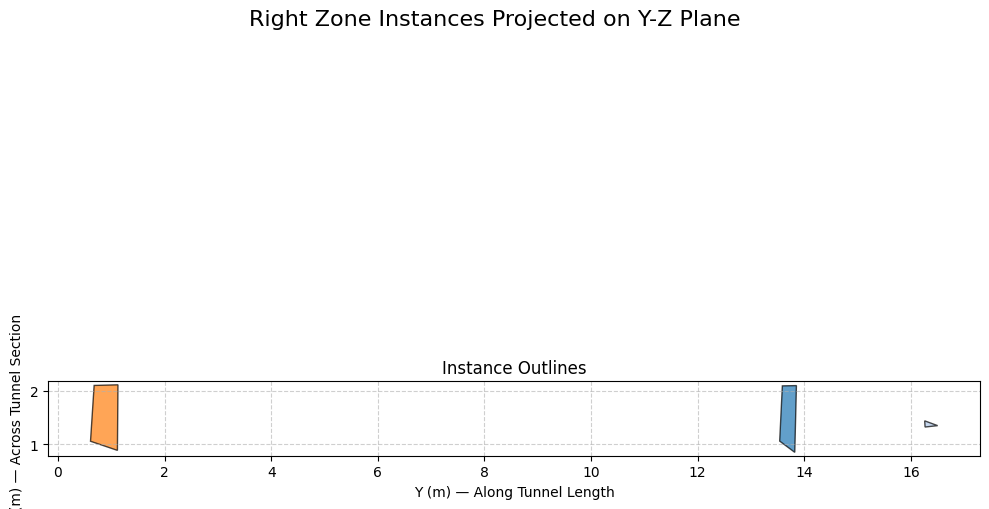

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as MplPolygon
import numpy as np
import cv2

# ====================================================
# Configuration
csv_path = "stuff_3d_points.csv"
panoptic_img_path = "Galleria SESTRI DX A10_s07_panoptic_seg.png"

# Tunnel geometry parameters
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
L = 20.0        # Tunnel length (m)
pix_range = 1800  # Pixel range from the center line to define boundaries

# ====================================================
# Load Data and Check for 'z' Column
try:
    df = pd.read_csv(csv_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{csv_path}'. Please ensure the path is correct.")
    exit()

if 'z' not in df.columns:
    print(f"Error: The CSV file '{csv_path}' is missing the 'z' column, which is required for Y-Z plane visualization.")
    exit()

# Ensure correct data types
df = df.dropna(subset=["x", "y", "z"])
df[["x", "y", "z"]] = df[["x", "y", "z"]].astype(float)
df["instance_id"] = df["instance_id"].astype(str)

# ====================================================
# Calculate the 3D Coordinate Boundaries for Filtering
try:
    img = cv2.imread(panoptic_img_path)
    height_img, width_img = img.shape[:2]
except (AttributeError, TypeError):
    print(f"Error: Could not read image file '{panoptic_img_path}'.")
    exit()

theta_max = s / r
half_span = r * np.sin(theta_max / 2)
theta_at_range = (pix_range / width_img) * theta_max
X_boundary_raw = r * np.sin(theta_at_range)
shift = half_span
X_filter_min = -X_boundary_raw + shift
X_filter_max = X_boundary_raw + shift

print(f"Defining left/right zones using X-boundary: < {X_filter_min:.3f} m and > {X_filter_max:.3f} m")

# ====================================================
# Split Data into Left and Right Zones
df_left = df[df["x"] < X_filter_min]
df_right = df[df["x"] > X_filter_max]

print(f"\nFound {df_left['instance_id'].nunique()} unique instances in the Left Zone.")
print(f"Found {df_right['instance_id'].nunique()} unique instances in the Right Zone.")

# ====================================================
# Reusable Plotting Function
# ====================================================
def plot_yz_projection(dataframe, zone_name):
    """
    Receives a DataFrame and a zone name, then generates a single
    Y-Z plane projection plot of the instances within that zone.
    """
    if dataframe.empty:
        print(f"\nNo instances found in the {zone_name}. Skipping plot.")
        return

    print(f"\nGenerating visualization for {zone_name}...")
    
    groups = dataframe.groupby("instance_id")
    
    # Color mapping
    cmap = plt.colormaps.get("tab20")
    num_groups = len(groups)
    
    # Create a single figure and axis
    fig, ax = plt.subplots(figsize=(10, 8))
    fig.suptitle(f"{zone_name} Instances Projected on Y-Z Plane", fontsize=16)

    for i, (name, group) in enumerate(groups):
        # Use Y and Z coordinates for the projection
        points = group[["y", "z"]].values
        
        if len(points) >= 3:
            # Ensure the polygon is closed for proper filling
            if not np.array_equal(points[0], points[-1]):
                points = np.vstack([points, points[0]])

            color = cmap(i % cmap.N)
            polygon = MplPolygon(points, closed=True, facecolor=color, edgecolor='black', alpha=0.7)
            ax.add_patch(polygon)

    # Set plot properties
    ax.set_aspect('equal')
    ax.autoscale()
    ax.set_xlabel("Y (m) — Along Tunnel Length")
    ax.set_ylabel("Z (m) — Across Tunnel Section")
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_title("Instance Outlines")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# ====================================================
# Call the Plotting Function for Each Zone
# ====================================================
# Plot 1: Left Zone Instances
plot_yz_projection(df_left, "Left Zone")

# Plot 2: Right Zone Instances
plot_yz_projection(df_right, "Right Zone")

In [43]:
import pandas as pd
import numpy as np
import cv2
from tqdm import tqdm

# ====================================================
# 1. Configuration
# ====================================================
input_csv_path = "stuff_3d_points.csv"
panoptic_img_path = "Galleria SESTRI DX A10_s07_panoptic_seg.png"
output_csv_path = "stuff_3d_points_with_zones.csv"

# ====================================================
# 2. Tunnel Geometry Parameters
# ====================================================
r = 5.05        # Radius (m)
s = 18.66       # Arc length (m)
pix_range = 1800  # Pixel range from the center line for defining zones

# ====================================================
# 3. Load and Preprocess Data
# ====================================================
print(f"Loading data from '{input_csv_path}'...")
try:
    df = pd.read_csv(input_csv_path)
except FileNotFoundError:
    print(f"Error: CSV file not found at '{input_csv_path}'. Please ensure the path is correct.")
    exit()
    
# Basic data cleaning for required columns
df = df.dropna(subset=["x", "y", "instance_id", "category_name"])

# Set correct data types for the columns that exist in the input file
df[["x", "y"]] = df[["x", "y"]].astype(float)
df["instance_id"] = df["instance_id"].astype(int)
df["category_name"] = df["category_name"].astype(str)

print(f"Data loaded successfully. Found {len(df)} points across {df['instance_id'].nunique()} unique instances.")

# ====================================================
# 4. Calculate Zone Boundaries from Image Geometry
# ====================================================
print("Calculating coordinate boundaries for zones...")
try:
    img = cv2.imread(panoptic_img_path)
    height_img, width_img = img.shape[:2]
except (AttributeError, TypeError):
    print(f"Error: Could not read image file '{panoptic_img_path}' to get its width.")
    exit()

theta_max = s / r
half_span = r * np.sin(theta_max / 2)

theta_at_range = (pix_range / width_img) * theta_max
X_boundary_raw = r * np.sin(theta_at_range)

shift = half_span
X_filter_min = -X_boundary_raw + shift
X_filter_max = X_boundary_raw + shift

print(f"Image Width: {width_img}px")
print(f"Calculated Center Zone X-Range (m): {X_filter_min:.3f} to {X_filter_max:.3f}")

# ====================================================
# 5. Classify Instances into Zones
# ====================================================
print("Classifying each instance into a zone based on its position...")

groups = df.groupby("instance_id")
# Create a dictionary to map each instance_id to its zone ('l', 'c', or 'r')
zone_map = {}

for instance_id, group in tqdm(groups, desc="Processing Instances"):
    x_min_instance = group['x'].min()
    x_max_instance = group['x'].max()
    
    # Core classification logic:
    # An instance is in the center if ANY part of it is in the center zone.
    if x_max_instance >= X_filter_min and x_min_instance <= X_filter_max:
        zone_map[instance_id] = 'c'  # Center
    # An instance is in the left zone only if its ENTIRETY is to the left.
    elif x_max_instance < X_filter_min:
        zone_map[instance_id] = 'l'  # Left
    # An instance is in the right zone only if its ENTIRETY is to the right.
    elif x_min_instance > X_filter_max:
        zone_map[instance_id] = 'r'  # Right

# Print classification statistics
zone_counts = pd.Series(zone_map).value_counts()
print("\nInstance classification complete:")
print(f"  - Center Zone ('c') instances: {zone_counts.get('c', 0)}")
print(f"  - Left Zone ('l') instances:   {zone_counts.get('l', 0)}")
print(f"  - Right Zone ('r') instances:  {zone_counts.get('r', 0)}")

# ====================================================
# 6. Add 'zone' Column and Save the New CSV
# ====================================================
print(f"\nAdding 'zone' column and saving the result...")

# Use the map function to efficiently add the zone label to every row
df['zone'] = df['instance_id'].map(zone_map)

# Save the complete DataFrame with the new 'zone' column to a new file
df.to_csv(output_csv_path, index=False)
print(f"✅ Successfully saved the data with zone information to '{output_csv_path}'.")

Loading data from 'stuff_3d_points.csv'...
Data loaded successfully. Found 50 points across 8 unique instances.
Calculating coordinate boundaries for zones...
Image Width: 6432px
Calculated Center Zone X-Range (m): 0.518 to 9.198
Classifying each instance into a zone based on its position...


Processing Instances: 100%|██████████| 8/8 [00:00<00:00, 771.21it/s]


Instance classification complete:
  - Center Zone ('c') instances: 5
  - Left Zone ('l') instances:   0
  - Right Zone ('r') instances:  3

Adding 'zone' column and saving the result...
✅ Successfully saved the data with zone information to 'stuff_3d_points_with_zones.csv'.
